In [1]:
try: 
  %tensorflow_version 2.x
  %reload_ext tensorboard
except:
  pass

In [2]:
!git clone https://github.com/PetraVidnerova/rbf_keras.git

Cloning into 'rbf_keras'...
remote: Enumerating objects: 120, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 120 (delta 0), reused 1 (delta 0), pack-reused 116
Receiving objects: 100% (120/120), 23.88 KiB | 334.00 KiB/s, done.
Resolving deltas: 100% (66/66), done.


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow
import keras
from keras import layers
from rbf_keras import kmeans_initializer
from tensorflow.keras.initializers import Initializer
from rbf_keras import rbflayer
from tensorflow.keras.optimizers import RMSprop

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
path='/content/drive/MyDrive/ANN_Data/HW03/auto-mpg.csv'
data = pd.read_csv(path,na_values=['NA', '?'])
print(f"horsepower has na? {pd.isnull(data['horsepower']).values.any()}")

horsepower has na? True


In [7]:
for index, row in data.iterrows():
    for col in data.columns:
        if row[col]=='?':
          print(index,col)

In [8]:
med = data['horsepower'].median()
print(med)
data['horsepower'] = data['horsepower'].fillna(med)
print(f"horsepower has na? {pd.isnull(data['horsepower']).values.any()}")

93.5
horsepower has na? False


In [9]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

X = data.drop(['mpg','car name'],axis=1).values   # independant features
y = data[['mpg']].values				# dependant variable


min_max_scaler_x = preprocessing.MinMaxScaler()
normalized_x = min_max_scaler_x.fit_transform(X)
X = pd.DataFrame(normalized_x)

min_max_scaler_y = preprocessing.MinMaxScaler()
normalized_y = min_max_scaler_y.fit_transform(y)
y = pd.DataFrame(normalized_y)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
X_test.shape

(80, 7)

# **kmeans**

In [66]:
from keras import backend as K

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))

In [67]:
def create_rbf_models(k):
  
  rbfLayer = rbflayer.RBFLayer(k,initializer=kmeans_initializer.InitCentersKMeans(X_train),
                              betas=4.0,
                              input_shape=(7,))
  model = keras.models.Sequential()
  model.add(layers.Input(shape=(7),name="Input_layer"))
  model.add(rbfLayer)
  model.add(layers.Dense(1))
  return model

In [68]:
ks = np.array([5,10,50,100,150])
models = []
for k in ks:
  model = create_rbf_models(k)  
  model.compile(loss='mse',optimizer=RMSprop())
  models.append(model)

In [69]:
histories=[]
for model in models:
  history = model.fit(X_train,y_train,epochs=300, validation_split=0.125)
  print("*"*100)
  histories.append(history)

Epoch 1/300
9/9 [==============================] - 1s 20ms/step - loss: 0.2407 - val_loss: 0.2535
Epoch 2/300
9/9 [==============================] - 0s 4ms/step - loss: 0.2136 - val_loss: 0.2318
Epoch 3/300
9/9 [==============================] - 0s 4ms/step - loss: 0.1941 - val_loss: 0.2135
Epoch 4/300
9/9 [==============================] - 0s 5ms/step - loss: 0.1765 - val_loss: 0.1959
Epoch 5/300
9/9 [==============================] - 0s 4ms/step - loss: 0.1599 - val_loss: 0.1792
Epoch 6/300
9/9 [==============================] - 0s 4ms/step - loss: 0.1441 - val_loss: 0.1632
Epoch 7/300
9/9 [==============================] - 0s 4ms/step - loss: 0.1293 - val_loss: 0.1482
Epoch 8/300
9/9 [==============================] - 0s 4ms/step - loss: 0.1151 - val_loss: 0.1334
Epoch 9/300
9/9 [==============================] - 0s 4ms/step - loss: 0.1016 - val_loss: 0.1196
Epoch 10/300
9/9 [==============================] - 0s 4ms/step - loss: 0.0892 - val_loss: 0.1072
Epoch 11/300
9/9 [==========

In [70]:
for model in models:
  model.evaluate(X_test,y_test)
  print("*"*50)

3/3 [==============================] - 0s 3ms/step - loss: 0.0037
**************************************************
3/3 [==============================] - 0s 4ms/step - loss: 0.0030
**************************************************
3/3 [==============================] - 0s 4ms/step - loss: 0.0031
**************************************************
3/3 [==============================] - 0s 4ms/step - loss: 0.0036
**************************************************
3/3 [==============================] - 0s 5ms/step - loss: 0.0043
**************************************************


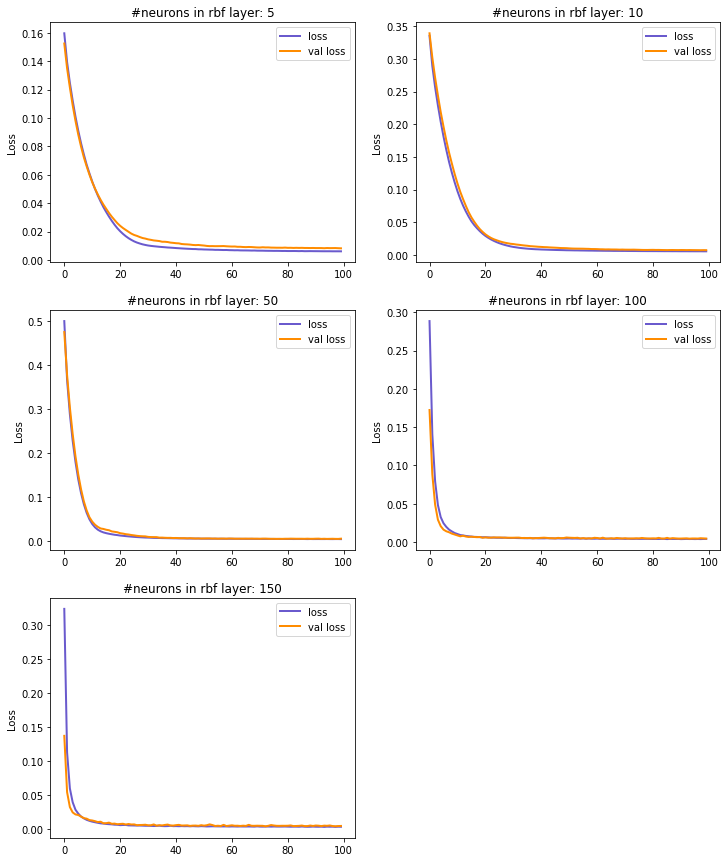

In [65]:
plt.figure(figsize=(12,15))
for i,history in enumerate(histories):
  plt.subplot(3, 2, i+1)
  plt.plot(history.history['loss'], label = 'loss',c="slateblue",linewidth=2)
  plt.plot(history.history['val_loss'], label='val loss',c="darkorange",linewidth=2)
  # plt.grid(True)
  plt.title("#neurons in rbf layer: "+str(ks[i]))
  plt.ylabel("Loss")
  plt.legend()
plt.savefig("part_3_1")

## one at a time

In [40]:
rbfLayer = rbflayer.RBFLayer(150,initializer=kmeans_initializer.InitCentersKMeans(X_train),
                             betas=4.0,
                             input_shape=(7,))
model = keras.models.Sequential()
model.add(layers.Input(shape=(7),name="Input_layer"))
model.add(rbfLayer)
model.add(layers.Dense(1))

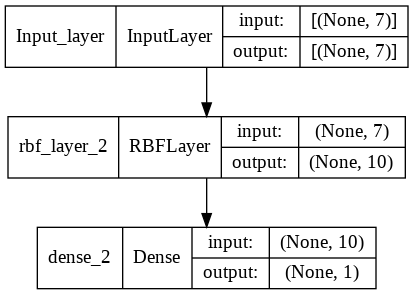

In [28]:
from keras.utils.vis_utils import plot_model

plot_model(model,show_shapes=True,show_layer_names=True)

In [41]:
model.compile(loss='mse',
              optimizer=RMSprop())

In [42]:
history = model.fit( X_train,y_train, epochs=100,validation_split= 0.125)

Epoch 1/100
9/9 [==============================] - 1s 19ms/step - loss: 0.2489 - val_loss: 0.1155
Epoch 2/100
9/9 [==============================] - 0s 5ms/step - loss: 0.1067 - val_loss: 0.0624
Epoch 3/100
9/9 [==============================] - 0s 5ms/step - loss: 0.0575 - val_loss: 0.0381
Epoch 4/100
9/9 [==============================] - 0s 5ms/step - loss: 0.0336 - val_loss: 0.0282
Epoch 5/100
9/9 [==============================] - 0s 5ms/step - loss: 0.0216 - val_loss: 0.0209
Epoch 6/100
9/9 [==============================] - 0s 6ms/step - loss: 0.0151 - val_loss: 0.0162
Epoch 7/100
9/9 [==============================] - 0s 5ms/step - loss: 0.0117 - val_loss: 0.0150
Epoch 8/100
9/9 [==============================] - 0s 5ms/step - loss: 0.0099 - val_loss: 0.0124
Epoch 9/100
9/9 [==============================] - 0s 4ms/step - loss: 0.0092 - val_loss: 0.0134
Epoch 10/100
9/9 [==============================] - 0s 5ms/step - loss: 0.0084 - val_loss: 0.0117
Epoch 11/100
9/9 [==========

In [43]:
model.evaluate(X_test,y_test)

3/3 [==============================] - 0s 4ms/step - loss: 0.0040


0.0040344735607504845

In [ ]:
prediction = model.predict(X_test)
prediction

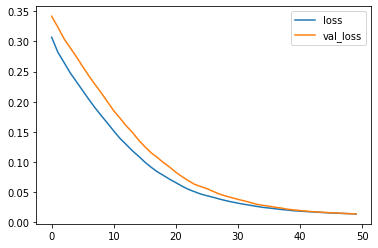

In [ ]:
pd.DataFrame(history.history).plot()

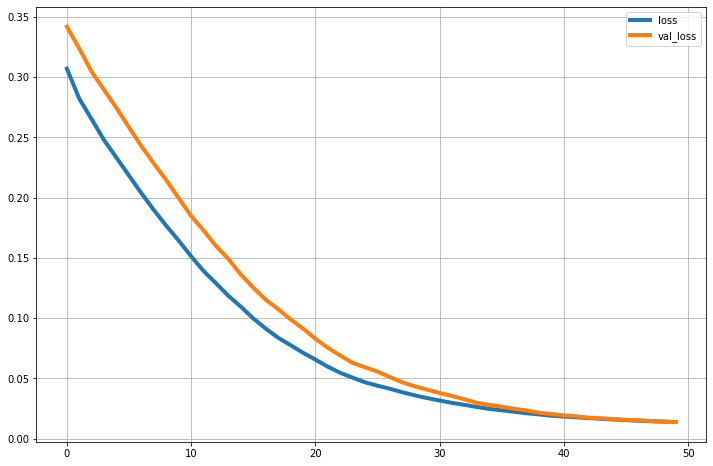

In [ ]:
pd.DataFrame(history.history).plot(figsize=(12, 8),linewidth=4)
plt.grid(True)
# plt.gca().set_ylim(0, 2) # set the vertical range to [0-1]
plt.show()

In [ ]:
# normalized_pred = model.predict(test[:,1:8])
pred = min_max_scaler_y.inverse_transform(prediction)
print(pred)

In [ ]:
yt = min_max_scaler_y.inverse_transform(y_test)
print(yt)

## plot best one

In [11]:
rbfLayer = rbflayer.RBFLayer(100,initializer=kmeans_initializer.InitCentersKMeans(X_train),
                             betas=4.0,
                             input_shape=(7,))
model = keras.models.Sequential()
model.add(layers.Input(shape=(7),name="Input_layer"))
model.add(rbfLayer)
model.add(layers.Dense(1))

model.compile(loss='mse',optimizer=RMSprop())

In [12]:
history = model.fit( X_train,y_train, epochs=100,validation_split= 0.125)

Epoch 1/100
9/9 [==============================] - 1s 25ms/step - loss: 0.1226 - val_loss: 0.0787
Epoch 2/100
9/9 [==============================] - 0s 5ms/step - loss: 0.0738 - val_loss: 0.0575
Epoch 3/100
9/9 [==============================] - 0s 5ms/step - loss: 0.0563 - val_loss: 0.0454
Epoch 4/100
9/9 [==============================] - 0s 5ms/step - loss: 0.0448 - val_loss: 0.0367
Epoch 5/100
9/9 [==============================] - 0s 6ms/step - loss: 0.0359 - val_loss: 0.0294
Epoch 6/100
9/9 [==============================] - 0s 5ms/step - loss: 0.0290 - val_loss: 0.0246
Epoch 7/100
9/9 [==============================] - 0s 5ms/step - loss: 0.0238 - val_loss: 0.0218
Epoch 8/100
9/9 [==============================] - 0s 5ms/step - loss: 0.0197 - val_loss: 0.0171
Epoch 9/100
9/9 [==============================] - 0s 5ms/step - loss: 0.0168 - val_loss: 0.0150
Epoch 10/100
9/9 [==============================] - 0s 6ms/step - loss: 0.0144 - val_loss: 0.0130
Epoch 11/100
9/9 [==========

In [13]:
model.evaluate(X_test,y_test)

3/3 [==============================] - 0s 4ms/step - loss: 0.0035


0.003477285150438547

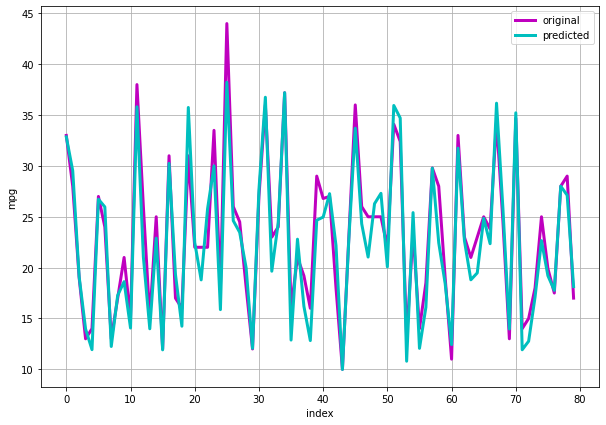

In [14]:
normalized_pred = model.predict(X_test)
pred = min_max_scaler_y.inverse_transform(normalized_pred)

y_test_original = min_max_scaler_y.inverse_transform(y_test)
plt.figure(figsize=(10,7))
plt.plot(y_test_original, label = 'original',c="m",linewidth=3)
plt.plot(pred, label='predicted',c="c",linewidth=3)
plt.xlabel('index')
plt.ylabel('mpg')
plt.grid(True)
plt.legend()

# **OLS**

In [ ]:
import math
import numpy as np
from numpy.linalg import qr, inv, norm

In [ ]:
Q, R = qr(X)

In [ ]:
R

array([[-11.91133914,  -8.22114164,  -7.1796768 ,  -8.75293219,
         -6.44923688,  -6.99753395,  -2.14081723],
       [  0.        ,  -1.74298436,  -1.00530484,  -0.94226457,
          2.55769835,   2.9401394 ,   3.89777455],
       [  0.        ,   0.        ,   2.12952246,   0.85651516,
          1.77758741,   2.51920697,   4.56406151],
       [  0.        ,   0.        ,   0.        ,   1.89845567,
          3.6394358 ,   3.72731521,   1.41671186],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          5.18891294,   4.79670151,   3.79464836],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   6.05559649,   0.74934795],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,  -6.23904213]])

In [ ]:
Q.shape

(398, 7)

In [ ]:
# Calculate G
F_T_g = X[0].transpose().dot(X[1])
F_T_F = X[0].transpose().dot(X[0])
G = X[1] - (F_T_g/F_T_F)*X[0]

# Turn F and G into unit vectors
F = X[0] / norm(X[0])
G = G / norm(G)

np.column_stack((F, G))

array([[ 0.08395362, -0.04166619],
       [ 0.08395362,  0.02208144],
       [ 0.08395362, -0.02535866],
       [ 0.08395362, -0.0461137 ],
       [ 0.08395362, -0.0490787 ],
       [ 0.08395362,  0.13919916],
       [ 0.08395362,  0.17626173],
       [ 0.08395362,  0.15550669],
       [ 0.08395362,  0.17774424],
       [ 0.08395362,  0.08138155],
       [ 0.08395362,  0.07100403],
       [ 0.08395362,  0.00725641],
       [ 0.08395362,  0.09620658],
       [ 0.08395362,  0.17774424],
       [ 0.01679072, -0.01248425],
       [ 0.05037217, -0.04486525],
       [ 0.05037217, -0.04338275],
       [ 0.05037217, -0.04190025],
       [ 0.01679072, -0.03620429],
       [ 0.01679072, -0.03620429],
       [ 0.01679072, -0.01693175],
       [ 0.01679072, -0.02137926],
       [ 0.01679072, -0.02582677],
       [ 0.01679072, -0.00062422],
       [ 0.05037217, -0.04338275],
       [ 0.08395362,  0.03690646],
       [ 0.08395362, -0.04166619],
       [ 0.08395362, -0.02535866],
       [ 0.08395362,

In [ ]:
np.dot(F,G)

-2.3305196179644047e-15

In [ ]:
from sklearn import linear_model

regr = linear_model.LinearRegression()
regr.fit(X, y)

LinearRegression()

In [ ]:
regr.coef_

array([[-0.05591398,  0.1961159 , -0.06060925, -0.62823615,  0.04383459,
         0.24120916,  0.07576136]])

In [ ]:
regr.intercept_

array([0.44865497])

In [ ]:
H = np.dot(Q.T,Q)

In [ ]:
H.shape

(7, 7)

In [ ]:
H_inv  = np.linalg.inv(H)

In [ ]:
g = np.dot(H_inv,Q.T)
g_hat = np.dot(g,y)

In [ ]:
g_hat

array([[-4.50496   ],
       [ 2.93943635],
       [ 2.8338817 ],
       [ 1.87551248],
       [ 5.10117986],
       [ 2.1324751 ],
       [-0.80244342]])

In [ ]:
E = y - np.dot(Q,g_hat)

In [ ]:
E

,0
0,0.173672
1,0.037033
2,0.128568
3,0.046965
4,0.158786
...,...
393,0.015706
394,0.047890
395,0.171460
396,-0.072258


In [ ]:
Q.shape

(398, 7)

In [ ]:
l = np.zeros(shape=(Q.shape[0],1))
for i in range(Q.shape[0]):
  l[i] = (np.dot(Q[i].T,Q[i])+ np.dot(E.T,E))

# sorted(l,reverse=True)

In [ ]:
l = np.ndarray.flatten(l)

4.934754708709011

In [ ]:
l_sorted = l.argsort()[::-1][:Q.shape[0]]

In [ ]:
np.array([X.iloc[13]]).shape

(1, 7)

In [ ]:
class InitCentersOLS(Initializer):


    def __init__(self, X, max_iter=100):
        self.X = X
        self.max_iter = max_iter
        super().__init__()

    def __call__(self, shape, dtype=None):
      centers = np.zeros(shape=shape)
      for i in range(shape[0]):
         np.append(centers, X.iloc[int(l_sorted[i])])
        # centers[i] = X.iloc(int(l_sorted[i]))
      return centers

 
        # return np.array([X.iloc[13],X.iloc[8],X.iloc[28],X.iloc[6],X.iloc[27]])

In [ ]:
X.iloc[(l_sorted[1])]

0    1.000000
1    1.000000
2    0.972826
3    0.797278
4    0.119048
5    0.000000
6    0.000000
Name: 8, dtype: float64

In [ ]:
c = kmeans_initializer.InitCentersKMeans(X_train)

In [ ]:
(c.__call__((2,7)))

array([[ 2.19512195e-01,  1.13592677e-01,  1.90233961e-01,
         2.13300532e-01,  5.02141405e-01,  6.02642276e-01,
         5.21341463e-01],
       [ 8.20895522e-01,  5.78232867e-01,  4.56683971e-01,
         6.00063899e-01,  3.99120469e-01,  3.88681592e-01,
        -2.77555756e-16]])

In [ ]:
rbfLayer = rbflayer.RBFLayer(50,initializer=InitCentersOLS(X),
                             betas=4.0,
                             input_shape=(7,))
model = keras.models.Sequential()
model.add(rbfLayer)
model.add(layers.Dense(1))

In [ ]:
model.compile(loss='mse',
              optimizer=RMSprop())

In [ ]:
history = model.fit( X_train,y_train, epochs=100,validation_split= 0.125)

Epoch 1/100
9/9 [==============================] - 1s 21ms/step - loss: 0.1767 - val_loss: 0.1612
Epoch 2/100
9/9 [==============================] - 0s 5ms/step - loss: 0.1514 - val_loss: 0.1413
Epoch 3/100
9/9 [==============================] - 0s 6ms/step - loss: 0.1394 - val_loss: 0.1321
Epoch 4/100
9/9 [==============================] - 0s 5ms/step - loss: 0.1324 - val_loss: 0.1246
Epoch 5/100
9/9 [==============================] - 0s 6ms/step - loss: 0.1259 - val_loss: 0.1192
Epoch 6/100
9/9 [==============================] - 0s 6ms/step - loss: 0.1207 - val_loss: 0.1140
Epoch 7/100
9/9 [==============================] - 0s 6ms/step - loss: 0.1152 - val_loss: 0.1089
Epoch 8/100
9/9 [==============================] - 0s 5ms/step - loss: 0.1099 - val_loss: 0.1035
Epoch 9/100
9/9 [==============================] - 0s 6ms/step - loss: 0.1049 - val_loss: 0.0987
Epoch 10/100
9/9 [==============================] - 0s 6ms/step - loss: 0.1002 - val_loss: 0.0940
Epoch 11/100
9/9 [==========

In [ ]:
model.evaluate(X_test,y_test)

4/4 [==============================] - 0s 3ms/step - loss: 0.0362


0.036201659590005875

In [ ]:
def gs(X, row_vecs=True, norm = True):
    if not row_vecs:
        X = X.T
    Y = X[0:1,:].copy()
    for i in range(1, X.shape[0]):
        proj = np.diag((X[i,:].dot(Y.T)/np.linalg.norm(Y,axis=1)**2).flat).dot(Y)
        Y = np.vstack((Y, X[i,:] - proj.sum(0)))
    if norm:
        Y = np.diag(1/np.linalg.norm(Y,axis=1)).dot(Y)
    if row_vecs:
        return Y
    else:
        return Y.T

In [ ]:
gs = gs(X)

KeyError: ignored